In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
xtickers = "COST CMCSA SBUX F MCD LOW HD CL PM MO PEP KO CVX OXY COP MET ALL MS AIG USB BLK BAC LLY MRK ABT PFE BIIB JNJ BMY DD UPS GD MMM HON LMT QCOM V NVDA ADBE GOOGL MA NFLX IBM VZ DUK NEE".split(" ")
ytickers = "DIS NKE CHTR AMZN TGT GM BKNG PG MDLZ WBA WMT KMI SLB XOM BK C JPM SPG AXP WFC COF GS AMGN ABBV MDT CVS DHR UNH GILD EMR CAT GE UNP BA FDX TXN AAPL ACN CSCO ORCL GOOG MSFT INTC T EXC SO".split(" ")
# Read and print the stock tickers that make up S&P500
tickers = [val for pair in zip(xtickers, ytickers) for val in pair]

In [5]:
# Get the data for this tickers from yahoo finance
data = yf.download(tickers,'2021-1-1','2021-7-12', auto_adjust=True)['Close'][:100]
print(data.shape)
data.head()

[*********************100%%**********************]  92 of 92 completed

(100, 92)


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMZN,AXP,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,127.002106,92.173622,103.105194,245.115555,485.339996,34.397247,98.912155,204.389359,159.331497,113.141541,...,333.932373,188.985229,147.621368,40.665340,212.716660,48.899712,35.157169,27.566044,46.623547,36.027855
2021-01-05,128.572357,93.126747,104.380890,246.511002,485.690002,34.971603,98.134262,205.381241,160.925507,113.745384,...,329.441620,191.303223,145.566544,40.797604,209.541885,48.675362,34.953362,28.336411,46.375366,37.764133
2021-01-06,124.244377,92.322273,104.163559,249.206238,466.309998,37.250557,100.660141,210.331802,156.919006,117.953209,...,343.267120,195.306168,145.133972,43.213531,207.695694,49.265316,36.541378,30.341211,46.664913,38.727779
2021-01-07,128.484024,93.310371,105.174660,251.557449,477.739990,37.880508,100.733337,211.026184,158.108002,117.020203,...,348.770569,198.024429,143.295486,44.077629,208.858093,49.154461,38.435108,31.028042,46.661728,39.031620
2021-01-08,129.592972,93.800034,105.467606,252.474976,485.100006,37.630383,100.623528,215.056961,159.134995,117.135628,...,347.203644,203.703033,142.745712,43.486874,210.460114,48.541397,38.392639,30.805290,46.655369,39.465694


In [6]:
data.reset_index(inplace=True, drop=True)
current = data.iloc[0]
dataln = np.log(current/data)

In [7]:
data_norm = dataln - dataln.mean()
data_norm = data_norm/data_norm.std()
col = data_norm.columns

In [8]:
curr = data_norm.drop(99, axis=0)
pre = data_norm.drop(0, axis=0)

In [11]:
import src.model.DYNOTEARS.run_dynotears as run_dynotears
from src.model.GOLEMTS.model import GolemTS
import src.model.GOLEMTS.trainer as trainer

In [12]:
Y = data_norm.to_numpy()
Yt = np.append(Y[:99], Y[1:], axis=1)
model = GolemTS(n=99, d=Y.shape[1], p=1, Y=Yt, device=None, 
                lambda_1=0.1, lambda_2=1, A_init=None, ev=True, lr=3e-3, lambda_3=9)

In [13]:
likes, evs = trainer.train(model, Yt, epochs=10_000, warmup_epochs=0, log=False, device=None,)


/Users/tylergibbs/dsc180/src/model/GOLEMTS/model.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y.clone().detach(), dtype=torch.float32)
/Users/tylergibbs/dsc180/src/model/GOLEMTS/trainer.py:30: RuntimeWarning: invalid value encountered in scalar divide
  if es and np.abs(score.cpu().detach().numpy() - scores[-1]) / scores[-1] < es_tol:


In [14]:
model_B = model.B.detach().numpy()
model_B[np.abs(model_B) < 0.2] = 0
model_A = model_B[:, :Y.shape[1]]

In [15]:
np.fill_diagonal(model_A, 0)

In [24]:
df = pd.DataFrame(model_A[:92])
df.columns = col
df.shape

(92, 92)

In [17]:
#df = df[col]

#df = df.transpose()[col].transpose()
#sl = dict([(i, tickers[i]) for i in range(len(tickers))])
#df = df.transpose()
df.columns = col
df = df[tickers]
df = df.transpose()
df.columns = col
df = df[tickers]
df.transpose()


Ticker,COST,DIS,CMCSA,NKE,SBUX,CHTR,F,AMZN,MCD,TGT,...,NFLX,MSFT,IBM,INTC,VZ,T,DUK,EXC,NEE,SO
Ticker,,,,,,,,,,,,,,,,,,,,,
COST,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
DIS,0.0,0.000000,0.211361,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
CMCSA,0.0,0.305418,0.000000,0.000000,0.0,0.476746,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
NKE,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
SBUX,0.0,0.000000,0.000000,0.204193,0.0,0.000000,0.0,0.0,0.210155,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
DUK,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.286201,0.255578,0.236482
EXC,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.241025,0.000000,0.000000,0.000000


Text(79, 90, 'Utilities')

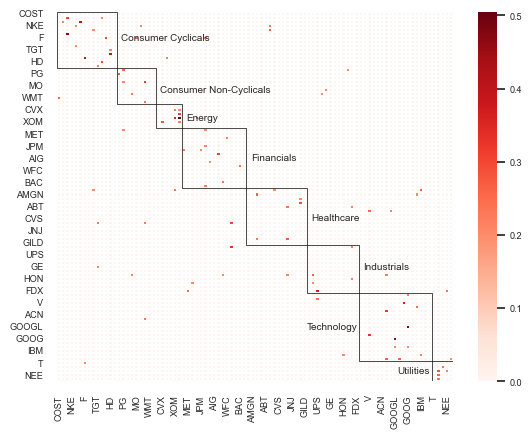

In [18]:
import matplotlib.patches as patches
sns.set(font_scale=.6)
ax = sns.heatmap(abs(df),  cmap='Reds',linewidths=.05);
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('', fontsize=10)

ax.add_patch(
     patches.Rectangle(
         (0, 0),
         14,
         14,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )

ax.text(15, 7, "Consumer Cyclicals")

ax.add_patch(
     patches.Rectangle(
         (14, 14),
         23-14,
         23-14,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )


ax.text(24, 20, "Consumer Non-Cyclicals")

ax.add_patch(
     patches.Rectangle(
         (23, 23),
         29-23,
         29-23,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )


ax.text(30, 27, "Energy")

ax.add_patch(
     patches.Rectangle(
         (29, 29),
         44-29,
         44-29,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )

ax.text(45, 37, "Financials")

ax.add_patch(
     patches.Rectangle(
         (44, 44),
         58-44,
         58-44,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )

ax.text(59, 52, "Healthcare")

ax.add_patch(
     patches.Rectangle(
         (58, 58),
         70-58,
         70-58,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )

ax.text(71, 64, "Industrials")

ax.add_patch(
     patches.Rectangle(
         (70, 70),
         87-70,
         87-70,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )

ax.text(58, 79, "Technology")


ax.add_patch(
     patches.Rectangle(
         (87, 87),
         5,
         5,
         edgecolor='black',
         fill=False,
         lw=.5
     ) )

ax.text(79, 90, "Utilities")

#plt.savefig('stocks.png', dpi=1500)

In [19]:
ax

<Axes: >